<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/03_clasification_sonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# **Descripcion**
---
El archivo "sonar.mines" contiene 111 patrones obtenidos al hacer rebotar señales de sonar en un cilindro de metal en varios ángulos y bajo diversas condiciones. El archivo "sonar.rocks" contiene 97 patrones obtenidos de rocas en condiciones similares. La señal del sonar transmitida es un chirrido de frecuencia modulada, aumentando en frecuencia. El conjunto de datos contiene señales obtenidas desde una variedad de ángulos de aspecto diferentes, que abarcan 90 grados para el cilindro y 180 grados para la roca.

Cada patrón es un conjunto de 60 números en el rango de 0,0 a 1,0. Cada número representa la energía dentro de una banda de frecuencia particular, integrada durante un cierto período de tiempo. La apertura de integración para frecuencias más altas ocurre más tarde en el tiempo, ya que estas frecuencias se transmiten más tarde durante el chirrido.

La etiqueta asociada a cada registro contiene la letra "R" si el objeto es una roca y "M" si es una mina (cilindro de metal). Los números en las etiquetas están en orden creciente de ángulo de aspecto, pero no codifican el ángulo directamente.




# **Objetivo**
---

Distinguir entre `rocas` y `estructuras metálicas`, como minas marinas en el fondo marino.

# **Dicionario de datos**
---
- [V1:V60] señales de sonar 
- Class: tipo de elemento
  - 0 Minas
  - 1 Rocas

# **Data**
---

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Sonar.csv')
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1


In [6]:
data_values = data.values
X = data_values[:, :60].astype('float32')
y = data_values[:, 60]

In [9]:
encoder = LabelEncoder()
encoder_y = encoder.fit_transform(y)
encoder_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, x_label:str='churm',y_label:str='count', c1 = '0', c2 = '1')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  _, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  ax.set_xticklabels([f'{c1} \n {ps}', f'{c2} \n{pe}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

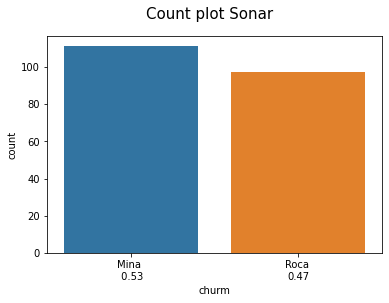

In [17]:
plot_bars(y, title = 'Sonar', c2='Roca', c1='Mina')

- El conjunto se encuntra parcialmente equilibrado

In [11]:
def model_base():
  model = Sequential()
  model.add(Dense(60, input_dim = 60, kernel_initializer='glorot_uniform', activation = 'relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation = 'relu'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

In [25]:
model = KerasClassifier(build_fn=model_base, epochs=100, batch_size = 5, verbose = 0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
score = cross_val_score(model, X, encoder_y, cv = kfold)

In [26]:
score

array([0.71428573, 0.90476191, 0.90476191, 0.52380955, 0.85714287,
       0.76190478, 0.90476191, 0.95238096, 0.85000002, 0.55000001])

- La mayoria de los resultados mantiene un rango consiso, pero a unos resultados que desmuestrán falta de habilidad del modelo para diferenciar minas de rocas.

In [27]:
print(" Line base: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

 Line base: 79.24% (14.45%)


La dispersión es considerable, lo que indica ruido estadistico, por lo tanto es posible que el rendimiento se vea afectado.

# **Optimizar el rendimiento con procesamiento de datos**
---

In [ ]:
estimator = []
estimator.append(('standarize', StandardScaler()))
estimator.append(('mlp', KerasClassifier(build_fn=model_base, epochs = 100, batch_size = 5, verbose = 0)))

In [32]:
pipeline = Pipeline(estimator)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
score = cross_val_score(pipeline, X, encoder_y, cv = kfold)

In [33]:
score

array([0.85714287, 0.95238096, 0.66666669, 0.80952382, 0.95238096,
       0.80952382, 0.90476191, 0.85714287, 0.80000001, 0.85000002])

- Los resultados convergen mejor que el modelo entrenado con datos no estandarizados

In [34]:
print("Modelo Estandarizado: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

Modelo Estandarizado: 84.60% (7.96%)


La dispersión es más baja que el modelo base, por lo tanto la habilidad predictiva es más confiable que el base.

# **Topologias**
---

## **Topologia Pequeña**
---

In [36]:
def model_smaller():
  model = Sequential()
  model.add(Dense(30, input_dim=60,kernel_initializer = 'glorot_uniform',activation='relu'))
  model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation='sigmoid'))
  model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
estimator = []
estimator.append(('standarize', StandardScaler()))
estimator.append(('mlp', KerasClassifier(build_fn=model_smaller, epochs = 100, batch_size = 5, verbose = 0)))

In [38]:
pipeline = Pipeline(estimator)
score = cross_val_score(pipeline, X, encoder_y, cv = kfold)

In [40]:
score

array([0.85714287, 0.95238096, 0.76190478, 0.66666669, 0.95238096,
       0.85714287, 0.85714287, 0.90476191, 0.80000001, 0.94999999])

In [39]:
print("Modelo Estandarizado Topologia pequeña: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

Modelo Estandarizado Topologia pequeña: 85.60% (8.81%)


- El modelo con topologia pequeña, no difiere tanto del rendimiento del modelo base.

## **Topologia grande**
---

In [41]:
def model_large():
  model = Sequential()
  model.add(Dense(60, input_dim = 60, kernel_initializer = 'glorot_uniform', activation = 'relu'))
  model.add(Dense(30, kernel_initializer = 'glorot_uniform', activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

In [ ]:
estimators = []
estimators.append(('standarize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_large, epochs=100, batch_size = 5, verbose=0)))

In [43]:
pipeline = Pipeline(estimator)
score = cross_val_score(pipeline, X, encoder_y, cv = kfold)

In [44]:
score

array([0.76190478, 0.90476191, 0.80952382, 0.76190478, 0.95238096,
       0.90476191, 0.85714287, 1.        , 0.85000002, 0.94999999])

In [46]:
print("Modelo Estandarizado Topologia grande: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

Modelo Estandarizado Topologia grande: 87.52% (7.73%)


- La topologia grande no tubo una mejora significativa en comparación a las otras arquitecturas, cabe resaltar que no se entro en profundidad.